In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as tts 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
df = pd.read_csv('HeartDisease.csv')


## Problem Statement - Analyze the heart disease dataset to explore the machine  learning algorithms and build a decision tree model to predict the disease  

## Dataset Information

##### Age:- Age of the patient
##### gender:- gender of the patient (0,1) - (Male,Female)
##### Chest_pain:- it refers to the chest pain experienced by the patient
##### rest_bps:- bloof pressure of teh patient while resting (in mm/ hg)
##### cholesterol:- patient cholesterol level (in mg/ dl)
##### fasting_blood_sugar:- the blood sugar of patient while fasting
##### rest_ecg:- potassium level(0,1,2)
##### thalach:- patient's maximum heart rate
##### exer_angina:- it refer to exercise-induced angina -(1 = Yes, 0 = No)
##### old_peak:- it is the st depression by exercise relative to rest (st relates to the position ECG plots)
##### slope:- it refer to the slope of the peak of the exercise ST- Segment(0,1,2)
##### ca:- Number of mejor vessels (0,1,2,3,4)
##### thalassemia:- it refer to the thalassemia which is a blood disorder (0,1,2,3)
##### target:- the patient has heart disease or not (1 = Yes, 0 = No) 

* Checking the null values is there any column that have most of the values are null
* Duplicated Values 
* drop Duplicated  Values if have any 
* in case of Classification Check does data Balanced or not
* Train Test Split 

In [3]:
# Null values Check 
df.isnull().sum()

age                    0
gender                 0
chest_pain             0
rest_bps               0
cholestrol             0
fasting_blood_sugar    0
rest_ecg               0
thalach                0
exer_angina            0
old_peak               0
slope                  0
ca                     0
thalassemia            0
target                 0
dtype: int64

In [4]:
# Check duplicate values 
df.duplicated().sum()

1

In [5]:
df[df.duplicated(keep = False)]

,age,gender,chest_pain,rest_bps,cholestrol,fasting_blood_sugar,rest_ecg,thalach,exer_angina,old_peak,slope,ca,thalassemia,target
163,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1
164,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1


In [6]:
# drop the Duplicated value
df.drop_duplicates(inplace = True)

In [7]:
# data is Balanced or not 
df['target'].value_counts(1)

1    0.543046
0    0.456954
Name: target, dtype: float64

## Data Preprocessing 

In [8]:
x = df.drop(columns = 'target')
y = df['target']

In [9]:
x_train, x_test , y_train, y_test = tts(x,y, random_state = 42, test_size = 0.25)
x_train.shape, x_test.shape , y_train.shape, y_test.shape

((226, 13), (76, 13), (226,), (76,))

In [10]:
# function that found the outlier in data

def CheckOutliers(df):
    columns = [ i for i in df.columns if df[i].dtype != "O"]
    ol= pd.DataFrame({'method':[],'Column':[],'No_of_outliers':[],'Persantage_of_outliers':[]})
    
    for col in columns:
        if -0.5 < df[col].skew() < 0.5:
            ub = df[col].mean() + (df[col].std())*3
            lb = df[col].mean() - (df[col].std())*3
            outliers = len(df[(df[col] > ub) | (df[col] < lb)][col])
            perchentage_of_Outlier = round((outliers/len(df)) * 100,2)
            temp = pd.DataFrame({'method':['Z-Score'],'Column':[col],'No_of_outliers':[outliers],
                                 'Persantage_of_outliers':[perchentage_of_Outlier]})
            
            ol = pd.concat([ol,temp]).reset_index(drop = True)
            
        else:
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1
            lw = q1 - 1.5*(iqr)
            uw = q3 + 1.5*(iqr)
            
            outliers = len(df[(df[col] > uw) | (df[col] < lw)][col])
            perchentage_of_Outlier = round((outliers/len(df)) * 100,2)
            tempp = pd.DataFrame({'method':['IQR'],'Column':[col],'No_of_outliers':[outliers],
                                 'Persantage_of_outliers':[perchentage_of_Outlier]})
            
            ol = pd.concat([ol,tempp]).reset_index(drop = True)
    
    return ol

In [11]:
# Function that Found the Outlier index in data both train and test data  

def OutlierIndex(df, df1):
    columns = [ i for i in df.columns if df[i].dtype != "O"]
    indexes= []
    test_indexes = []
    for col in columns:
        if -0.5 < df[col].skew() < 0.5:
            ub = df[col].mean() + (df[col].std())*3
            lb = df[col].mean() - (df[col].std())*3
            
            outlier_index = df[(df[col] > ub) | (df[col] < lb)].index.tolist()
            test_outlier_index = df1[(df1[col] > ub) | (df1[col] < lb)].index.tolist()
            
            indexes.extend(outlier_index)
            test_indexes.extend(test_outlier_index)
            
        else:
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1
            lw = q1 - 1.5*(iqr)
            uw = q3 + 1.5*(iqr)
            
            outlier_index = df[(df[col] > uw) | (df[col] < lw)].index.tolist()
            test_outlier_index = df1[(df1[col] > uw) | (df1[col] < lw)].index.tolist()
            
            indexes.extend(outlier_index)
            test_indexes.extend(test_outlier_index)
            
            
    index = set(indexes)
    test_index = set(test_indexes)
    
    return pd.Series(list(index)), pd.Series(list(test_index))

In [12]:
col_series = x_train.nunique().sort_values(ascending = False)
numeric_data_columns = col_series[col_series>30].index

In [13]:
# We have very few outliers so we  can remove them

CheckOutliers(x_train[numeric_data_columns])

,method,Column,No_of_outliers,Persantage_of_outliers
0,IQR,cholestrol,4.0,1.77
1,Z-Score,thalach,0.0,0.00
2,IQR,rest_bps,7.0,3.10
3,Z-Score,age,0.0,0.00
4,IQR,old_peak,3.0,1.33


In [14]:
train_ot_index, test_ot_index = OutlierIndex(x_train[numeric_data_columns],x_test[numeric_data_columns])

In [15]:
# remove outliers from train and test data 
x_train.drop(index = train_ot_index, inplace = True)
y_train.drop(index = train_ot_index, inplace = True)

x_test.drop(index = test_ot_index, inplace = True)
y_test.drop(index = test_ot_index, inplace = True)

In [16]:
x_train.shape ,y_train.shape ,x_test.shape ,y_test.shape 

((212, 13), (212,), (71, 13), (71,))

#### Making the function that Evaluate the Model

In [17]:
result_df = pd.DataFrame({
        "method": [],
        "train_accuracy": [],
        "test_accuracy": [],
        "train_precision":[],
        'test_precision': [],
        'train_recall':[],
        "test_recall":[]
      })

def Evaluation(model, Method, x_train,y_train,x_test,y_test):
    
    # Model train on training the data 
    model.fit(x_train,y_train)
    
    # model prediction on train and test data 
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    # accuracy score 
    train_acc = accuracy_score(y_train,y_train_pred)
    test_acc  = accuracy_score(y_test,y_test_pred)
    
    # precision score
    train_pre = precision_score(y_train,y_train_pred)
    test_pre = precision_score(y_test,y_test_pred)
    
    # re_call score 
    train_rec = recall_score(y_train, y_train_pred)
    test_rec = recall_score(y_test, y_test_pred)
    
    temp_df = pd.DataFrame({
        "method": [Method],
        "train_accuracy": [train_acc],
        "test_accuracy": [test_acc],
        "train_precision":[train_pre],
        'test_precision': [test_pre],
        'train_recall':[train_rec],
        "test_recall":[test_rec]
      })
    
    global result_df
    
    result_df = pd.concat([result_df,temp_df])
    
    cm = confusion_matrix(y_test, y_test_pred)
    cm_plot = ConfusionMatrixDisplay(cm)
    cm_plot.plot()
    
    return result_df

In [18]:
# now it's time to train the model
# import decision tree Classifier 
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()


,method,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall
0,only outliers remove and not hyperperameter tu...,1.0,0.788732,1.0,0.903226,1.0,0.7


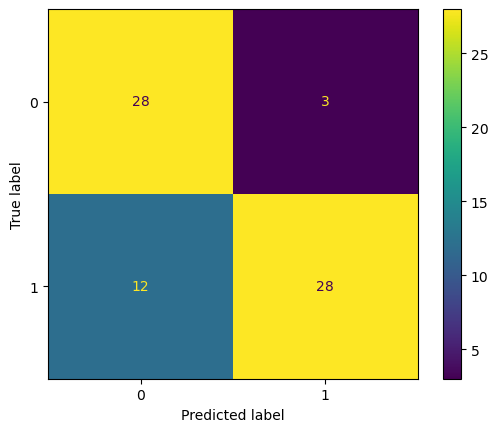

In [19]:
Evaluation(model,'only outliers remove and not hyperperameter tuning', x_train, y_train, x_test, y_test)

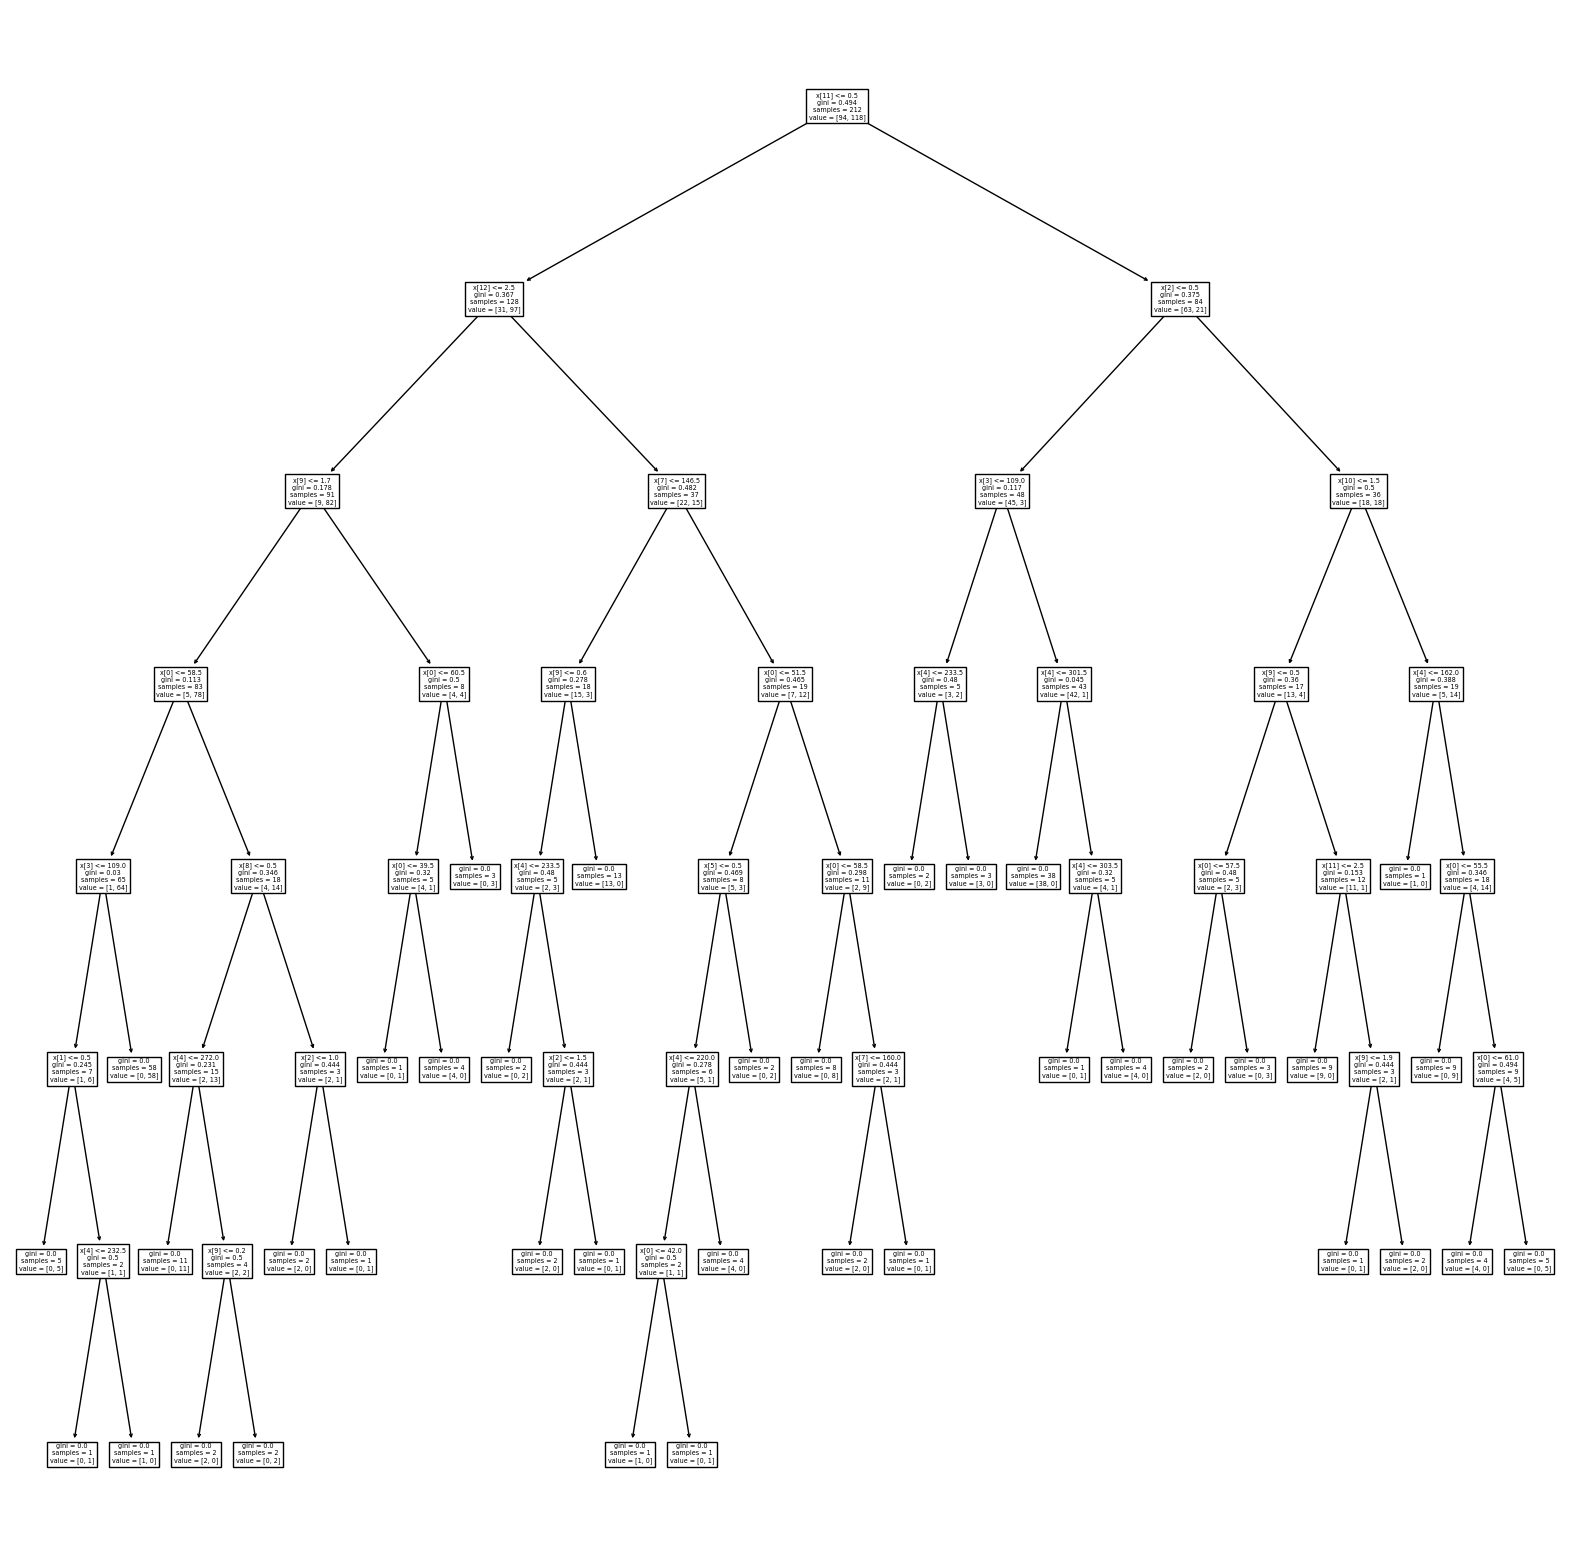

In [20]:
plt.figure(figsize = (20,20))
from sklearn import tree
tree.plot_tree(model)
plt.show()

### post pruning (cost complexity alpha cca)

In [21]:
path  = model.cost_complexity_pruning_path(x_train,y_train)

In [22]:
path

{'ccp_alphas': array([0.        , 0.00309627, 0.00393082, 0.0043239 , 0.00460728,
        0.00566038, 0.00628931, 0.00628931, 0.00718753, 0.00754717,
        0.00865923, 0.00914808, 0.00920451, 0.01010451, 0.01132075,
        0.01158557, 0.01226415, 0.01331222, 0.0188478 , 0.02129213,
        0.03714623, 0.06097527, 0.12338271]),
 'impurities': array([0.        , 0.00928882, 0.01715046, 0.02579826, 0.03501283,
        0.04633358, 0.05262289, 0.0589122 , 0.08766232, 0.09520949,
        0.11252794, 0.12167603, 0.14008504, 0.16029407, 0.17161482,
        0.20637153, 0.21863568, 0.23194789, 0.25079569, 0.27208782,
        0.30923405, 0.37020932, 0.49359203])}

In [23]:
ccp_alphas = path.ccp_alphas
impurities = path.impurities

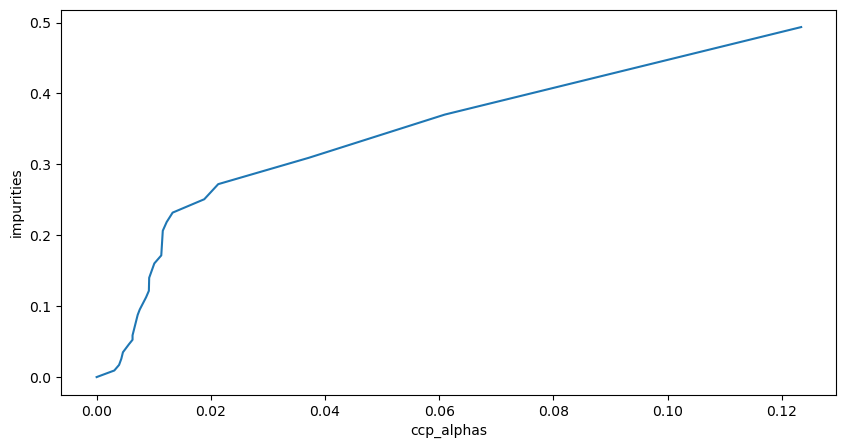

In [24]:
plt.figure(figsize = (10,5))
plt.plot(ccp_alphas,impurities)
plt.xlabel('ccp_alphas')
plt.ylabel('impurities')
plt.show()

In [25]:
models = []

for cc_a in  ccp_alphas:
    dc_model = DecisionTreeClassifier(random_state = 42, ccp_alpha = cc_a)
    dc_model.fit(x_train,y_train)
    models.append(dc_model)

In [26]:
# check the accuracy score for each model
acc_scores_test = [accuracy_score(y_test,i_model.predict(x_test))for i_model in models]
acc_scores_train = [accuracy_score(y_train,i_model.predict(x_train))for i_model in models]

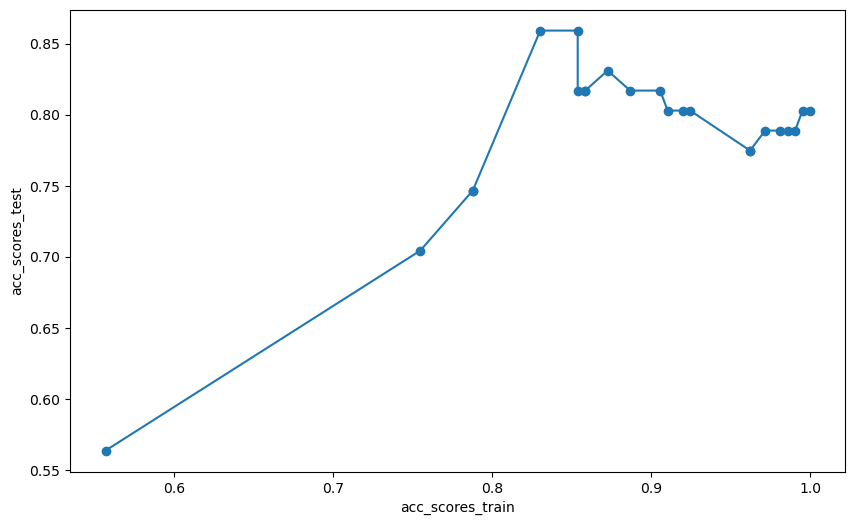

In [27]:
plt.figure(figsize = (10,6))
plt.plot(acc_scores_train,acc_scores_test, marker = 'o')
plt.xlabel('acc_scores_train')
plt.ylabel('acc_scores_test')
plt.show()


In [28]:
# index at  of highest test score 
np.argmax(np.array(acc_scores_test))

17

In [29]:
# so  at the ccp_alpha value = 0.013312216312898278 gives the best test score 
ccp_alphas[17]

0.013312216312898278

,method,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall
0,only outliers remove and not hyperperameter tu...,1.000000,0.788732,1.000000,0.903226,1.000000,0.7
0,only outliers remove and ccp_alpha = 0.01331221,0.853774,0.859155,0.837209,0.857143,0.915254,0.9


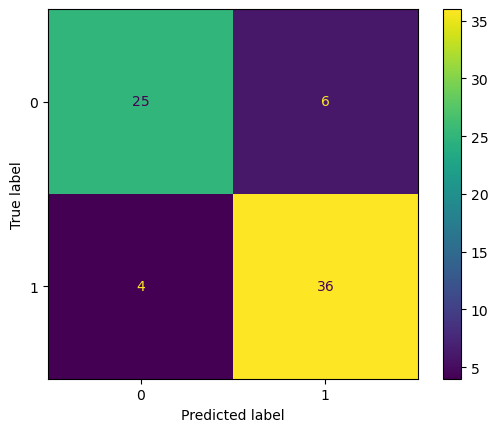

In [30]:
new_model =  DecisionTreeClassifier(random_state = 42, ccp_alpha = 0.013312216312898278)
Evaluation(new_model,'only outliers remove and  ccp_alpha = 0.01331221', x_train, y_train, x_test, y_test)

## Important Features

In [53]:
imp_features = pd.DataFrame(list(zip(new_model.feature_importances_,x_train.columns)))

In [57]:
imp_feature_col = imp_features[imp_features[0] > 0][1].values

,method,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall
0,only outliers remove and not hyperperameter tu...,1.000000,0.788732,1.000000,0.903226,1.000000,0.7
0,only outliers remove and ccp_alpha = 0.01331221,0.853774,0.859155,0.837209,0.857143,0.915254,0.9
0,"ot remove,ccp_alpha = 0.01331221, important fe...",0.853774,0.859155,0.837209,0.857143,0.915254,0.9


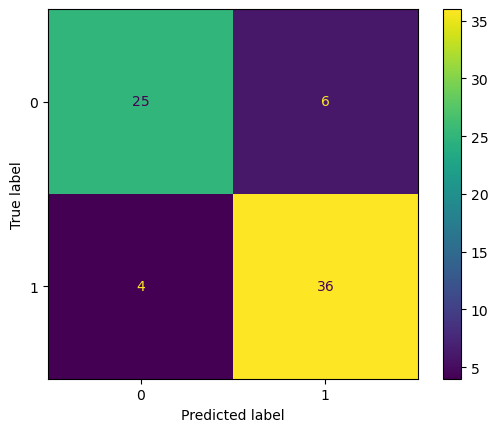

In [58]:
Evaluation(new_model,'ot remove,ccp_alpha = 0.01331221, important features', x_train[imp_feature_col], y_train, x_test[imp_feature_col], y_test)

### Final Model 

In [62]:
# Make the Object of  Model
clf = DecisionTreeClassifier(random_state = 42, ccp_alpha = 0.013312216312898278)

In [64]:
# Train the model on Training Data
clf.fit(x_train[imp_feature_col],y_train)

DecisionTreeClassifier(ccp_alpha=0.013312216312898278, random_state=42)

## Conclusin 
### """Your project demonstrated a systematic approach to predicting heart disease in patients. By thoroughly preprocessing the data, addressing duplicates, outliers, and performing feature selection, created a more generalized and efficient model. The final decision tree model, trained on important features, achieved significant accuracy, precision, and recall on both train and test data. This indicates that the model can reliably predict the presence of heart disease, making it a valuable tool for healthcare professionals."""






